# Final Presentation

Modify this notebook as the presentation notebook of your final presentation.

In [ ]:
print("Hello world!")

In [ ]:
%matplotlib inline
from typing import List, Tuple
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import animation, rc
from functools import partial

#%pip install power_grid_model

from power_grid_model.utils import json_deserialize, json_serialize

import matplotlib.animation
plt.rcParams["animation.html"] = "jshtml"

import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import matplotlib.transforms

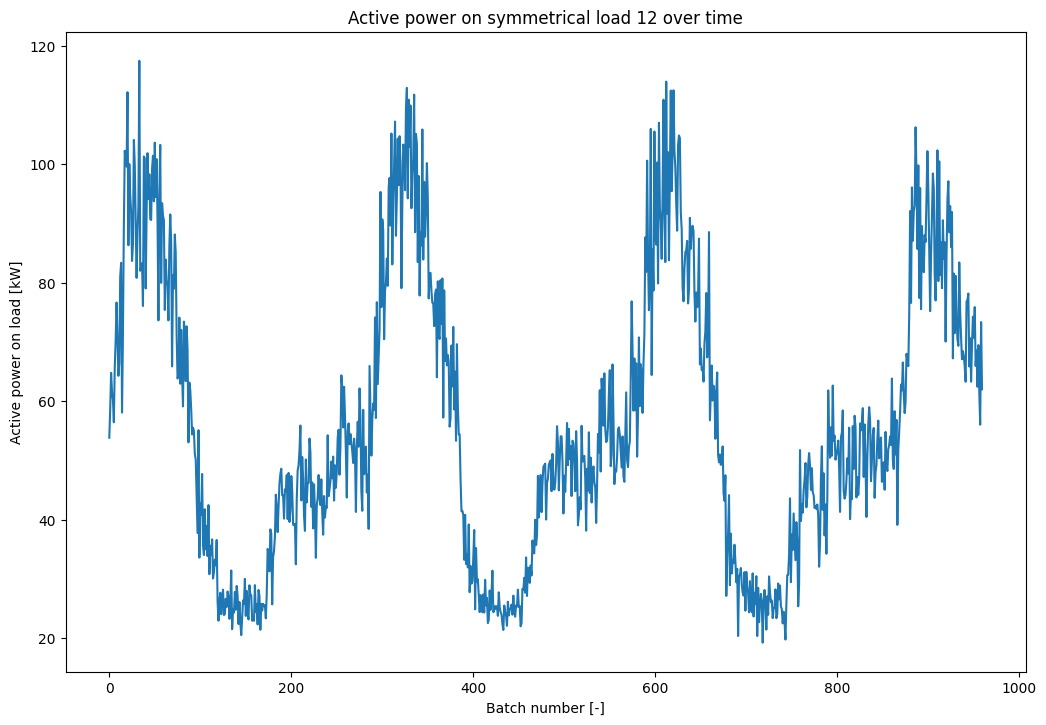

In [1]:
import os
import sys
import pytest

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
from power_grid_model.utils import json_deserialize, json_serialize

import power_system_simulation.pgm_processing as pgm_p

def test_pgm_processing():
    dir_network_json = "input_network_data.json"
    dir_active_profile = "active_power_profile.parquet"
    dir_reactive_profile = "reactive_power_profile.parquet"

    with open(dir_network_json) as fp:
        data = fp.read()
    network_data = json_deserialize(data)

    # Read active and reactive load profile from parquet file
    active_load_profile = pd.read_parquet(dir_active_profile)
    reactive_load_profile = pd.read_parquet(dir_reactive_profile)

    p = pgm_p.PgmProcessor(network_data, active_load_profile, reactive_load_profile)
    p.create_update_model()
    p.run_batch_process()
    aggregate_results = p.get_aggregate_results()

    # Save aggregate results (for drawing tests in external notebook as repository is not completed yet and cannot be used directly as-is)
    #aggregate_results[0].to_parquet("/calculated_output_per_timestamp.parquet")
    #aggregate_results[1].to_parquet(src_dir + "/calculated_output_per_line.parquet")

    # Change a timestamp in active profile to an incorrect one and check for error
    active_load_profile_wrong = active_load_profile.copy()
    active_load_profile_wrong.rename(
        index={active_load_profile.index[0]: pd.to_datetime("today").normalize()}, inplace=True
    )
    with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T0") as excinfo:
        p = pgm_p.PgmProcessor(network_data, active_load_profile_wrong, reactive_load_profile)
        p.create_update_model()

    # Change a node ID in active profile to an incorrect one and check for error
    active_load_profile_wrong = active_load_profile.copy()
    active_load_profile_wrong.rename(
        columns={active_load_profile.columns[0]: 1234567890}, inplace=True
    )
    with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T1") as excinfo:
        p = pgm_p.PgmProcessor(network_data, active_load_profile_wrong, reactive_load_profile)
        p.create_update_model()

    # Change a node ID in the network description to an incorrect one (different than reactive/active profile) and check for error
    network_data_wrong = network_data.copy()
    network_data_wrong["sym_load"][0][0] = 1234567890
    with pytest.raises(pgm_p.ProfilesDontMatchError, match=r".*T2") as excinfo:
        p = pgm_p.PgmProcessor(network_data_wrong, active_load_profile, reactive_load_profile)
        p.create_update_model()

    # Test if pre-calculated output data matches the aggregated output
    """
    dir_out_per_line = src_dir + "/output_table_row_per_line.parquet"
    dir_out_per_timestamp = src_dir + "/output_table_row_per_timestamp.parquet"

    assert (
        p.compare_to_expected(
            aggregate_results,
            pd.read_parquet(dir_out_per_line),
            pd.read_parquet(dir_out_per_timestamp),
        )
        == True
    )

    # Change the output data and check if the error is detected
    with pytest.raises(AssertionError) as excinfo:
        assert (
            p.compare_to_expected(
                aggregate_results,
                pd.read_parquet(dir_out_per_line),
                pd.read_parquet(dir_out_per_line),
            )
            == True
        )
        """

    # Drawing
    dir_network_json = "input_network_data.json"
    dir_active_profile = "active_power_profile.parquet"
    dir_reactive_profile = "reactive_power_profile.parquet"

    with open(dir_network_json) as fp:
        data = fp.read()
    network_data = json_deserialize(data)

    # Read active and reactive load profile from parquet file
    active_load_profile = pd.read_parquet(dir_active_profile)
    reactive_load_profile = pd.read_parquet(dir_reactive_profile)

    p = pgm_p.PgmProcessor(network_data, active_load_profile, reactive_load_profile)
    p.create_update_model()
    p.run_batch_process()
    fig, ax = plt.subplots(figsize=(16, 8))
    fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)
    #p.draw_to_networkx(aggregate_results, ax)

    # Loading is relative loading of the line, 1.0 meaning 100% loaded.
    # For power flow: lines show loading
    # Sym loads show... whatever is chosen (default to i)
    #p.draw_init_power_flow('u_pu')
    #p.draw_init()
    #p.adraw_timelapse_power_flow(3)

    # p.draw_aggregate_table[0].index.size
    #animation = matplotlib.animation.FuncAnimation(fig, p.draw_timelapse_power_flow, init_func=p.draw_init, frames=2, interval=250, blit=False)
    #animation.save("test.gif", writer='Pillow', dpi=100)
    #p.draw_static_line_loading('min_loading')
    #print(pd.DataFrame(p.output_data['sym_load'][0]).loc[0, 'p'])
    p.draw_static_simple_load_active(p.output_data, 12, ax)

test_pgm_processing()


                     Max_Voltage_Node  Max_Voltage  Min_Voltage_Node  \
Timestamp                                                              
2025-01-01 00:00:00               1.0     1.074434               0.0   
2025-01-01 00:15:00               1.0     1.075584               0.0   
2025-01-01 00:30:00               1.0     1.071253               0.0   
2025-01-01 00:45:00               1.0     1.074032               0.0   
2025-01-01 01:00:00               1.0     1.072835               0.0   
...                               ...          ...               ...   
2025-01-10 22:45:00               1.0     1.073071               0.0   
2025-01-10 23:00:00               1.0     1.076191               0.0   
2025-01-10 23:15:00               1.0     1.074557               0.0   
2025-01-10 23:30:00               1.0     1.073564               0.0   
2025-01-10 23:45:00               1.0     1.077326               0.0   

                     Min_Voltage  
Timestamp                   

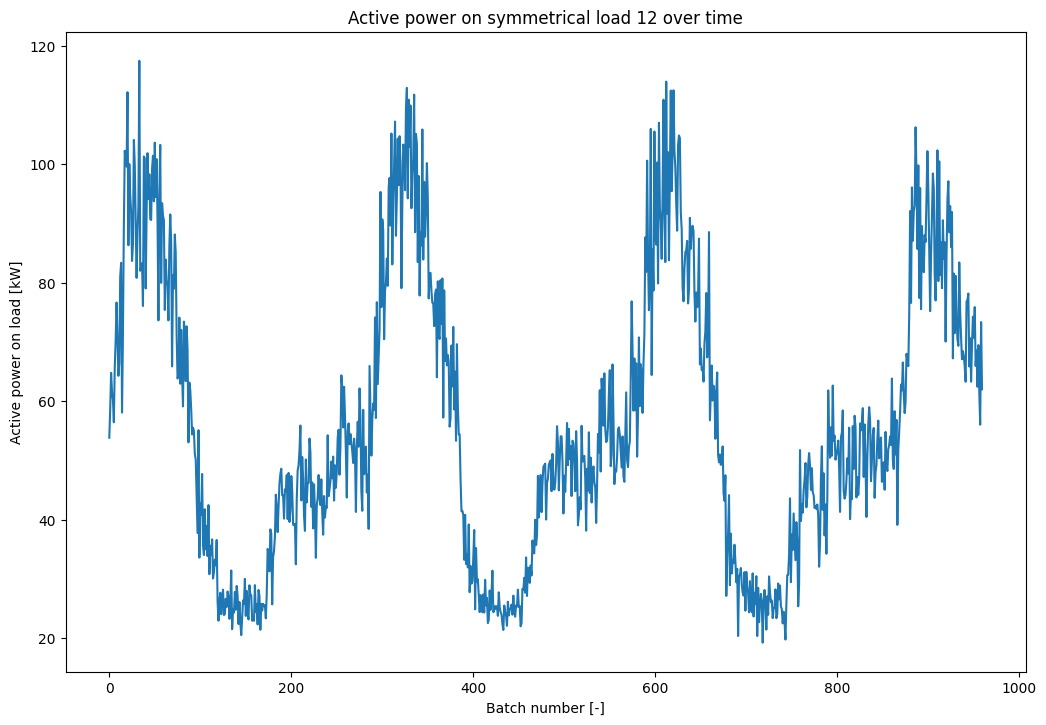

In [6]:
import os
import sys

import numpy as np
import pandas as pd
import pytest

import copy as copy
import json
import networkx as nx
from power_grid_model.utils import json_deserialize, json_serialize
import power_system_simulation.graph_processing as pss
import power_system_simulation.optimization as psso

import os
import sys
import pytest

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation

import matplotlib

meta_data = {}
network_data = {}
active_profile = {}
reactive_profile = {}
ev_active_profile = {}


def test_optimization():
    global network_data, meta_data, active_profile, reactive_profile, ev_active_profile
    dir_meta_data_json = "meta_data.json"
    dir_network_json = "input_network_data.json"
    dir_active_profile = "active_power_profile.parquet"
    dir_reactive_profile = "reactive_power_profile.parquet"
    dir_ev_active_profile =  "ev_active_power_profile.parquet"

    with open(dir_meta_data_json) as fp:
        data = fp.read()
    meta_data = json.loads(data)

    with open(dir_network_json) as fp:
        data = fp.read()
    network_data = json_deserialize(data)

    active_profile = pd.read_parquet(dir_active_profile)
    reactive_profile = pd.read_parquet(dir_reactive_profile)
    ev_active_profile = pd.read_parquet(dir_ev_active_profile)

    """
    Insert here the file that will be given. (not available yet)
    Choose a random seed to keep it consistent.
    
    Testing every error.
    
    EV penetration:
        Check if number  of EVs per LV feeder are correct in the end.
        Check random penetration levels, also if above 100% etc.
        
    Optimal tap position:
        Just a print.
    
    N-1 calculation:
        Check if the given Line ID is not a valid line.
        Check if given Line ID is not connected at both sides in the base case.
        Check the table if there are no alternatives.
        Just checking if it works with different line IDs.
    
    """
    p = psso.LV_grid(network_data, active_profile, reactive_profile, ev_active_profile, meta_data)
    p.n_1_calculation(18)
    
     # Test EV penetration level; Obtain aggregated results
    aggregate_results = p.EV_penetration_level(0.8, True)

    # Save aggregate results (for drawing tests in external notebook)
    #aggregate_results[0].to_parquet(src_dir + "/calculated_output_per_timestamp.parquet")
    #aggregate_results[1].to_parquet(src_dir + "/calculated_output_per_line.parquet")

    fig, ax = plt.subplots(figsize=(16, 8))
    fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)
    #p.draw_to_networkx(aggregate_results, ax)

    # Loading is relative loading of the line, 1.0 meaning 100% loaded.
    # For power flow: lines show loading
    # Sym loads show... whatever is chosen (default to i)
    #p.draw_init_power_flow('u_pu')
    #p.draw_init()
    #p.adraw_timelapse_power_flow(3)

    # p.draw_aggregate_table[0].index.size
    #animation = matplotlib.animation.FuncAnimation(fig, p.draw_timelapse_power_flow, init_func=p.draw_init, frames=2, interval=250, blit=False)
    #animation.save("test.gif", writer='Pillow', dpi=100)
    #p.draw_static_line_loading('min_loading')
    #print(pd.DataFrame(p.output_data['sym_load'][0]).loc[0, 'p'])

    print(p.House_Profile_Id)
    # Or random
    p.processor.draw_static_simple_load_active(p.processor.output_data, list(p.House_Profile_Id.keys())[0], ax)

    # Test optimal tap position
    #p.optimal_tap_position("energy_loss")
    #p.optimal_tap_position("voltage_deviation")
    # Test optimal tap position, with wrong directive (should return -1, -1)
    #assert set(p.optimal_tap_position("wrong_directive")) == set([-1, -1])
    
def test_errors():
    global network_data, meta_data, active_profile, reactive_profile, ev_active_profile

    # 2 The LV grid has exactly one transformer, and one source
    # 2.1 extra transformer
    test_2_transformer = copy.deepcopy(network_data)

    transformer2 = copy.deepcopy(test_2_transformer["transformer"][0])
    transformer2["id"] = 25
    test_2_transformer["transformer"] = np.append(test_2_transformer["transformer"], transformer2)
    with pytest.raises(psso.LvGridOneTransformerAndSource) as excinfo:
        psso.LV_grid(
            test_2_transformer, active_profile, reactive_profile, ev_active_profile, meta_data
        )
    # 2.2 extra source
    test_2_source = copy.deepcopy(network_data)
    source2 = copy.deepcopy(test_2_source["source"][0])
    source2["id"] = 25
    test_2_source["source"] = np.append(test_2_source["source"], source2)
    with pytest.raises(psso.LvGridOneTransformerAndSource) as excinfo:
        psso.LV_grid(test_2_source, active_profile, reactive_profile, ev_active_profile, meta_data)

    # 3 All IDs in the LV Feeder IDs are valid line IDs.
    test_valid_ids = copy.deepcopy(network_data)
    test_valid_ids["line"]["id"][0] = 25

    with pytest.raises(psso.LVFeederError, match=r".*T0") as excinfo:
        psso.LV_grid(test_valid_ids, active_profile, reactive_profile, ev_active_profile, meta_data)
    # 4 All the lines in the LV Feeder IDs have the from_node the same as the to_node of the transformer.
    test_same_nodes = copy.deepcopy(network_data)
    test_same_nodes["transformer"]["to_node"] = 2

    with pytest.raises(psso.LVFeederError, match=r".*T1") as excinfo:
        psso.LV_grid(
            test_same_nodes, active_profile, reactive_profile, ev_active_profile, meta_data
        )
    # 5 The grid is fully connected in the initial state.
    test_fully_connected = copy.deepcopy(network_data)
    test_fully_connected["line"]["to_status"][4] = 0
    test_fully_connected["line"]["from_status"][5] = 0

    with pytest.raises(pss.GraphNotFullyConnectedError) as excinfo:
        psso.LV_grid(
            test_fully_connected, active_profile, reactive_profile, ev_active_profile, meta_data
        )
    # 6 The grid has no cycles in the initial state.
    test_cycles = copy.deepcopy(network_data)
    test_cycles["line"]["to_status"][8] = 1

    with pytest.raises(pss.GraphCycleError) as excinfo:
        psso.LV_grid(test_cycles, active_profile, reactive_profile, ev_active_profile, meta_data)

    # 7 The timestamps are matching between the active load profile, reactive load profile, and EV charging profile.
    active_load_profile_wrong_time = copy.deepcopy(active_profile)
    active_load_profile_wrong_time.rename(
        index={active_profile.index[0]: pd.to_datetime("today").normalize()}, inplace=True
    )
    with pytest.raises(psso.ProfilesDontMatchError, match=r".*T0") as excinfo:
        psso.LV_grid(
            network_data,
            active_load_profile_wrong_time,
            reactive_profile,
            ev_active_profile,
            meta_data,
        )

    # 8 The IDs in active load profile and reactive load profile are matching.
    active_load_profile_wrong_ID = copy.deepcopy(active_profile)
    active_load_profile_wrong_ID.rename(
        columns={active_profile.columns[0]: 1234567890}, inplace=True
    )
    with pytest.raises(psso.ProfilesDontMatchError, match=r".*T1") as excinfo:
        psso.LV_grid(
            network_data,
            active_load_profile_wrong_ID,
            reactive_profile,
            ev_active_profile,
            meta_data,
        )

    # 9 The IDs in active load profile and reactive load profile are valid IDs of sym_load.
    test_sym_load = copy.deepcopy(network_data)
    test_sym_load["sym_load"]["id"][0] = 28
    with pytest.raises(psso.ProfilesDontMatchError, match=r".*T2") as excinfo:
        psso.LV_grid(test_sym_load, active_profile, reactive_profile, ev_active_profile, meta_data)

    # 10 The number of EV charging profile is at least the same as the number of sym_load.
    test_number_EV = copy.deepcopy(ev_active_profile)
    new_column = copy.deepcopy(test_number_EV[1])
    test_number_EV[4] = new_column
    with pytest.raises(psso.EvProfilesDontMatchSymLoad) as excinfo:
        psso.LV_grid(network_data, active_profile, reactive_profile, test_number_EV, meta_data)
    
test_optimization()
#test_errors()

p = psso.LV_grid(network_data, active_profile, reactive_profile, ev_active_profile, meta_data)
print(p.n_1_calculation(18))
